In [1]:
from PIL import Image, ImageSequence
import numpy as np
import functools
import kgpy.img.coalignment.image_coalignment as img_align
from numba import njit
from skimage.transform import rotate
import scipy.ndimage
import matplotlib.pyplot as plt
import astropy.units as u
import time


# Image Rotation in Python
Start first by testing out three different rotation codes and compare their speeds.

In [2]:
# a = np.random.rand(500, 500)
a = np.ones((1000, 1000))



In [3]:

def pillow_rotate(a,angle):
    if a.ndim == 2:
        im = Image.fromarray(a)
        im.rotate(angle,Image.BILINEAR)
        a = np.asarray(im)
    else:    
        b = np.moveaxis(a,-1,0)
        for i,img in enumerate(b):
            im = Image.fromarray(img)
            im.rotate(angle,Image.BILINEAR)
            a[...,i] = np.asarray(im)

    return a


In [4]:
ang = 10 * u.deg
# %timeit pillow_rotate(a,ang)
# %timeit rotate(a, ang, order=1)
# %timeit rotate(a, ang, order=3)
# %timeit scipy.ndimage.rotate(a,ang,prefilter = False, order = 1)

%time test = scipy.ndimage.rotate(a,ang,reshape = False)


CPU times: user 122 ms, sys: 11.3 ms, total: 133 ms
Wall time: 133 ms


In [5]:
def coord_rotate(img_shp,angle,origin):
    y,x = np.array(np.meshgrid(np.arange(img_shp[0]), np.arange(img_shp[1]))) - origin[...,None,None]

    c = np.cos(angle)
    s = np.sin(angle)

    x_prime = c*x + s*y
    y_prime = -s*x + c*y

    prime_coords = np.array([x_prime+origin[0],y_prime+origin[1]])
    return prime_coords

In [6]:
origin = np.array([(a.shape[0]-1)/2,(a.shape[1]-1)/2])
%time prime_coords = coord_rotate(a.shape,ang,origin)
%time rot_a = scipy.ndimage.map_coordinates(a,prime_coords)

CPU times: user 22.9 ms, sys: 11.8 ms, total: 34.7 ms
Wall time: 34.2 ms
CPU times: user 138 ms, sys: 309 µs, total: 138 ms
Wall time: 137 ms


4.6074255521943996e-14


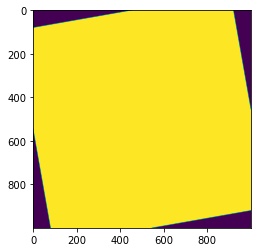

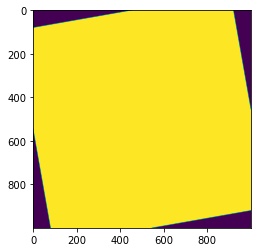

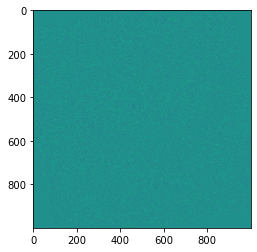

In [7]:
fig, ax = plt.subplots()
ax.imshow(rot_a)
fig, ax = plt.subplots()
ax.imshow(test)
fig, ax = plt.subplots()
ax.imshow(rot_a-test)
print(np.sum(rot_a-test))